# Hands-On ML: Chapter 4, Training Models

In this chapter, we will focus on what happens under the hood and how the models are fitted. Understanding how the models work will allow us to better home into the appropriate model, select the right training algorithm to use and tune hyperparameters. It will also help us with debugging issues and perform error analysis more efficiently. Lastly, we will begin to touch on understanding, building and training neural networks.

Summary

1. Linear Regressions
2. Computational Complexity
3. Solving optimization problems with Gradient Descent, Batch Gradient Descent, Stochastic Gradient Descent and Mini-batch Gradient Descent
4. Polynomial Regression
5. Learning Curve
6. Regularized Regression (Ridge, Lasso, Elastic Net)
7. Early Stopping Algo
8. Logistic, Decision Boundaries and Cross-Entropy

In [21]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## Linear Regressions

There are two primary ways to train linear regression models. **1)** Using a direct "closed-form" equation that computes the model parameters which best fit the model to the training set and **2)** An iterative optimizaiton approach called Gradient Descent that gradually twaks the model parameters to minimize the cost functio over the training set, eventually converging to the same set of parameters in the first method. Then we will examine a few of the variants: *i)* Batch GD *ii)* Mini-batch GD and *iii)* Stochastic GD.

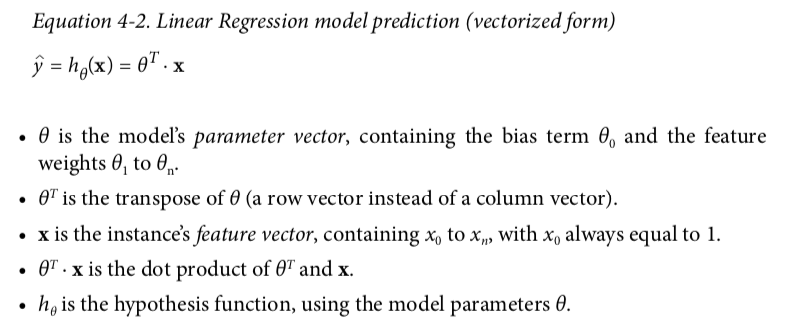

In [3]:
from IPython.display import Image
Image(filename='./images/linear_regression.png') 

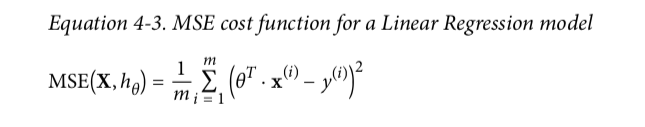

In [4]:
Image(filename='./images/linear_mse.png') 

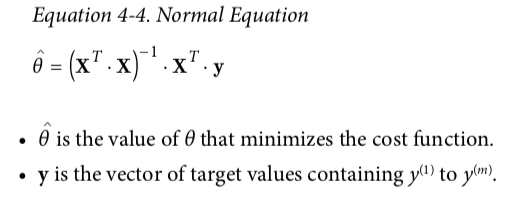

In [5]:
Image(filename='./images/normal_equation.png') 

In [6]:
#Nothing special here, this the closed form normal equation to solve for B vector
#Lets generate some linear looking data to play around
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [12]:
#Lets write out the normal equation to solve for beta
X_b = np.c_[np.ones((100, 1)), X] #each list inside this array is the predictors. Right now is [1, x1] so that we'll have nonzero B0 coefficient

inverse = np.linalg.inv(X_b.T.dot(X_b)) #use linalg.inv function to compute the inverse (X_t X)^-1
theta_best = inverse.dot(X_b.T).dot(y) #dot product with the rest
theta_best

array([[3.98400185],
       [3.09920002]])

In [25]:
#Make predictions
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] #add ones to have nonzero B0 coefficient
y_predict = X_new_b.dot(theta_best) #y-hat
y_predict

array([[ 3.98400185],
       [10.18240189]])

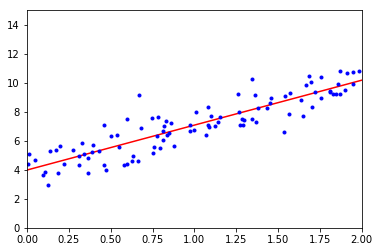

In [23]:
#Plot actual data vs our fitted line
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [26]:
#The sklearn code is:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_
lin_reg.predict(X_new)

array([[ 3.98400185],
       [10.18240189]])

## Computational Complexity 

Fitting models is an optimization problem-- hence, we need to understand computational complexity. The normal equation X_t X produces an nxn matrix (n number of features). The *computational complexity* of inversting such a matrix is typically about O(n^2.4) to O(n^3) depending on implementation. **In other words, if you double the number of features, you multiple the computation time by roughly 2^2.4 = 5.3 to 2^3 = 8.** Hence, the normal equation is *very* slow for large number of features. The positive is that the equation is linear in x and the computational complexity takes the form O(m).

O(1): Constant, computational time is independent on number of inputs

O(n): Time proportional to number of inputs

O(logN): Time proportional to log(number of inputs)

In addition to computational complexity of training, we should also look at computationl complexity of predicting (relationship to number of instances). The normal equation is O(n) for prediction, so it's relatively fast. When the number of features is great, we may need another way of fitting:

-----------

## Gradient Descent

Gradient descent is a very generic optimization algorithm capable of finding optimal solutions to wide range of problems. The idea is to tweak parameters iteratively in order to minimize a cost function. It measures the local gradient of the loss function with regards to θ and goes in the direction of steepest slope. In practice, you begin by:

1) Fill θ with random values (random initilization)
2) Gradually take steps to try and reduce the loss function (a key parameter called learning rate).
3) Continue until the algorithm converges to a minimum

If the learning rate is too small, it will take many iterations to converge. If the learning rate is too high, the algorithm may jump pass the minimum and miss the global optimum. Moreover, if it keeps jumping back and forth across, it may never converge.

------------

## Batch Gradient Descent

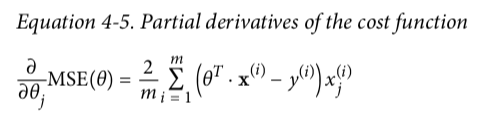

In [27]:
Image(filename='./images/partial_derivatives.png') 

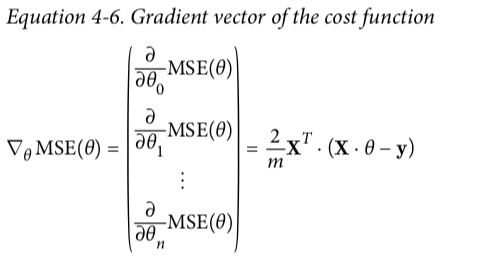

In [29]:
Image(filename='./images/gradient_vector.png') 

When we implement gradient descent, we calculate the gradient as a partial deriative. In addition, we can represent the different partial derivatives (with respect to each feature) as a gradient vector. **Batch Gradient Descent** is very slow!!! It is called batch because at each step, it needs to compute this gradient vector which requires the entire batch of training data. However, it scales well with the number of features, so for wide datasets it'll still be faster than the normal equation. 

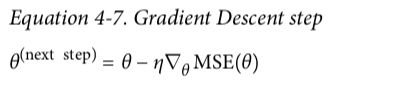

In [30]:
Image(filename='./images/gradient_descent_step.png') 

The algorithm computes the gradient at each step. We always compute the gradient vector pointing uphill. Therefore, "taking a step" simply means subtract the gradient vector from the theta vector. The learning rate will determine what factor we subtract. Aside from learning rate (the size of the step), we also care about the iteration (number of steps). For convex problems, it can be shown that the convergence rate is O(1/iterations). In practice, we usually choose a high number of iterations but stop the algorithm when the gradient vector becomes small enough, this is called **tolerance**. 

In [38]:
#Quick implementation
eta = 0.1
n_iterations = 1000
m = 100 #number of instances

theta = np.random.randn(2,1) #randomn initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y) #gradient formula
    theta = theta - eta * gradients
    
#We get the same B0, B1 as our initial regression problem!
theta

array([[3.98400185],
       [3.09920002]])

## Stochastic Gradient Descent

The main problem with Batch Gradient Descent is that it needs to use the entire training set which makes it slow. At the opposite extreme, Stochastic Gradient Descent just picks a random instance in the training set at every step and computes the gradients based on only that instance. Not only does it make the algorithm faster since there is less data to manipulate, but it also means only one instance needs to be in memory at each iteration and can be implemented as an out-of-core algorithm (which I presume allows you to handle datasets larger than your main memory since computation can exist in external memory).

Due to the stochastic component, SGD will bounce around instead of steadily decreasing until it reaches the minimum. This is actually good for irregular loss functions since SGD can jump out of local minima. But this also means it won't converge into an optima. One possible solution is *simulated annealing*, where the learning rate will gradually reduce. That way, SGD will jump less and emulate convergence. The function that determines what the learning rate is for each iteration is called *learning schedule*.


In [43]:
n_epochs = 50
t0, t1 = 5, 50 #learning schedule hyperparameters

#As t gets larger, the learning rate gets smaller
def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) #random initialization

for epoch in range(n_epochs):
    for i in range(m): #there are m number of instances
        random_index = np.random.randint(m) #randomly pick one
        xi = X_b[random_index:random_index + 1] #select x for that index
        yi = y[random_index: random_index + 1] #select y for that index
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi) #2 over 1
        eta = learning_schedule(epoch * m + i) #scale by number of epochs 
        theta = theta - eta * gradients #subtract theta vector with gradient

In [44]:
theta

array([[4.04590897],
       [3.10753151]])

In [58]:
#Lets use the sklearn implementation now
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter = 50, penalty = None, eta0 = 0.1) #50 epochs, starting eta of 0.1, default learning schedule
sgd_reg.fit(X, y.ravel()) #ravel will put them all into one array

sgd_reg.intercept_, sgd_reg.coef_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


(array([3.94838911]), array([3.0613365]))

## Mini-batch Gradient Descent

Mini-batch gradient descent is pretty simple-- it just the middle ground of BGD and SGD. Instead of picking just one instance to compute the gradient, it will pick a small random set of instances called *mini-batches* to compute the gradient. This is especially good when paired with GPUs since you can compute these matrix operations quite fast. The algorithms progress in parameter space is less erratice than SGD, but it will also have a harder time escaping local minima.

------------

## Polynomial Regression

Next, let's turn to a situation where our data is not so straightforward. How do we fit nonlinear data? One way is to use linear methods like polynomial regressions (and in extention spline regressions).

In [62]:
#Create data with quadratic relationship
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [73]:
#Fit a polynomial regression by create polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False) #degree 2 polynomial
X_poly = poly_features.fit_transform(X)

#Note that PolynomialFeatures also includes interactions. When we do degree = 3, not only will it have a^2, a^3, b^2, b^3
#ab, a^2b and ab^2

In [79]:
X_poly[1:4] #LHS is original X, RHS is the transformed polynomial X

array([[2.81838097, 7.94327128],
       [2.8744517 , 8.26247258],
       [0.37091859, 0.1375806 ]])

In [80]:
#Now we fit this as a two feature model with X and X^2
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.50235047]), array([[1.06458189, 0.43391535]]))

## Learning Curves

Learning curves let us estimate how much training data is necessary to build a model that generalizes well. It also tells us whether the model is over/under fitting. If the training curve is much lower than the validation curve, this suggests that the model may be overfitted.

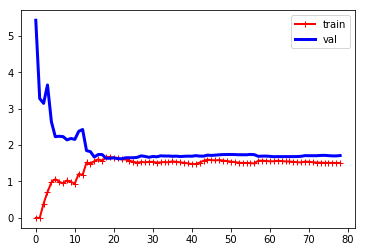

In [92]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2) #train test split the data
    train_errors, val_errors = [], [] #empty list to store errors
    for m in range(1, len(X_train)): #for m number of instances
        model.fit(X_train[:m], y_train[:m]) #fit the model
        y_train_predict = model.predict(X_train[:m]) #in sample prediction
        y_val_predict = model.predict(X_val) #out-of-sample prediction
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth = 2, label = 'train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth = 3, label = "val")
    plt.legend()
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

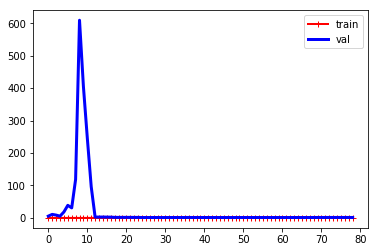

In [96]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline((
    ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)), #create polynomial features
    ('sgd_reg', LinearRegression()),
))

plot_learning_curves(polynomial_regression, X, y)

#For the graph, we should zoom in to see what happens in y < 100 range.

## Bias-Variance Tradeoff

This is an important concept in statistics and ML-- a model's generalization error (out-of-sample) can be expressed as the sum of three types of errors:

1) Bias: This is error due to wrong assumptions, such as assuming the data is linear when it is actually quadratic. A high-bias model is most likely to **underfit** the data.

2) Variance: This is error due to the model's excessive sensitivty to small variations in the training data. A high-variance model is most likely to **overfit** the data. Complex models with many degrees of freedom are likely to have high variance.

3) Irreducible Error: This is error due to noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g. fix the sensors that collect the data or remove outliers)

## Regularized Linear Models

A good way to reduce overfitting (lower variance) is to constrain the model. Regularization achieves this by constraining the weights of the model. We will look at three different ways: 1) Ridge Regression 2) Lasso Regression and 3) Elastic Net.

**A key point to remember is that regularization is only applied for training. When assessing the loss of the model, we should use the actual loss, not a regularized version.**

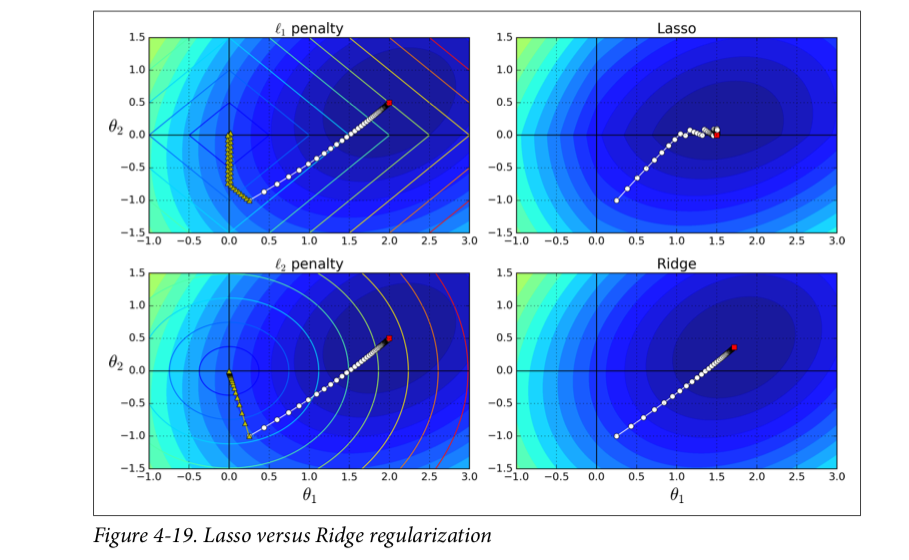

In [105]:
#Ridge versus Lasso Path
Image(filename = './images/ridge_vs_lasso_path.png')

### Ridge versus Lasso Path

This section requires a bit more explanation. BGD is initialized at theta_1 = 0.25 and theta_2 = -1.0. The background contour is an unregularized MSE function (and the regularized Lasso, Ridge for the top-right, bottom-right images).

**Top-Left:** This is L1 norm penalty. Yellow is when lambda = infinity and the optimizer quickly rolls down to theta_1 = 0 and then theta_2 = 0. White is when lambda = 0 and we see the unregularized BGD path.

**Bottom-Left:** This is L2 norm penalty. Yellow is when lambda = infinity, the optimizer rolls in a straight line to theta_1 = 0 and theta_2 = 0. White is when lambda = 0 so its the same.

**Top-Right:** This is L1 norm penalty with lambda = 0.5-- a lasso regression. Lasso quickly zeroes out coefficients; it rolls down to theta_2 = 0 immediately. The it slowly rolls down until theta_1 = 1.5.

**Bottom-Right:** This is L2 norm penalty with lambda = 0.5 -- a ridge regression. Again, the L2 will roll in a smoother manner until it reaches theta_1 = 1.75 and theta_2 = 0.3.


### Ridge Regression

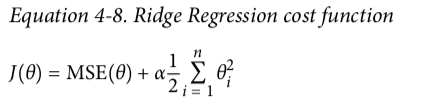

In [101]:
Image(filename='./images/ridge.png') 

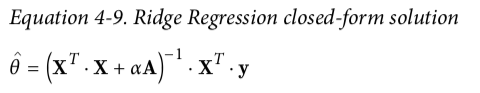

In [102]:
Image(filename='./images/ridge_closed_form.png') 

In [97]:
#Ridge regression
#We can either solve in closed-form or do SGD 
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.66835093]])

In [100]:
sgd_reg = SGDRegressor(penalty = 'l2') #for ridge, we use the l2 norm. This will automatically do 1/2 L2 norm.
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([4.86413495])

### Lasso Regression

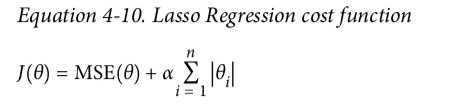

In [104]:
Image(filename='./images/lasso.png') 

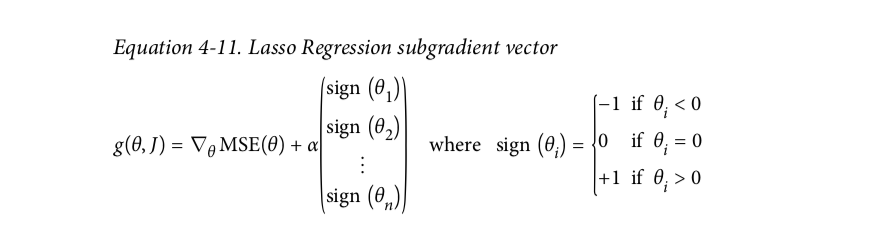

In [106]:
Image(filename='./images/lasso_subgradient.png')

The lasso is non-differentiable at theta = 0 since the left and right limits are not the same. We can still use GD by calculating the **subgradient vector**. Instead of calculating the partials of the entire MSE + Lasso function, we will calculate the partials of the MSE plus a signed vector to signal the lasso direction. **Not sure if this is the best, we can also do LARS (Least Angle Regression) which generalizes into Lasso.**

In [108]:
#Lasso Regression
#Lasso stands for Least Absolute Shrinkage and Selection Operator 
#The key characteristic of lasso is that it tends to eliminate least important features (set beta to zero)
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.63532483])

### Elastic net

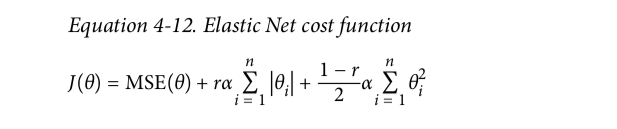

In [109]:
Image(filename = './images/elastic_net.png')

Nothing too special here. Elastic net is literally a blend of ridge and lasso methods. r will control the blend of ridge and lasso constraints. In terms of choosing between the three, there is a basic rule of thumb. If you suspect a lot of your features are not important, Lasso and Elastic Net are better. If you have a lot of features, Elastic Net is better than Lasso (since Lasso may behave erratically, especially if the features are correlated).

In [111]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.63253666])

## Early Stopping

An alternative to regularization-- which punishes overfitting in the loss function -- is early stopping. Early stopping, as the name suggests, is when an iterative model stops as soon as the **validation error** reaches a minimum. The idea is that training and validation error will go down as the model better fits the data with each epoch. But once the model begins to overfit, validation error will begin to increase. We just need to stop the training before that stage. **For SGD and MBGD** this will have some caveats. Both optimizers have sporadic behaviour and validation error may not decline steadily. One way is to stop only after the validation error has been above the minimum for some time, then roll back to the minimum weights.

In [127]:
from sklearn.base import clone

#no learning schedule, keep eta = eta0. warm_start reuses the previous fit as initialization, useful when we're fitting the model
#iteratively. n_iter is the number of iterations to reach stopping criteria. Set to 1 because we're writing our own stopping logic.
#With these settings, it will do SGD once, then stop. 

sgd_reg = SGDRegressor(max_iter = 1, tol = 0.20, warm_start = True, penalty = None,
                       learning_rate = "constant", eta0 = 0.0005) 

minimum_val_error = float("inf") #initialize as inf to ensure we get the first loop
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_poly, y.ravel()) #train the model
    y_val_predict = sgd_reg.predict(X_poly) #predict on test set
    val_error = mean_squared_error(y_val_predict, y.ravel()) #calculate validation error on test set
    if val_error < minimum_val_error:
        minimum_val_error = val_error #if we have lower error, thats now the minimum
        best_epoch = epoch #store which epoch was the best
        best_model = clone(sgd_reg) #store which model was the best

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1229: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1229: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1229: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:1229: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

In [128]:
best_model

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='squared_loss', max_iter=1,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=0.2, validation_fraction=0.1,
       verbose=0, warm_start=True)

In [129]:
best_epoch

742

In [130]:
minimum_val_error

0.8941015617876324

## Logistic Regression + Decision Boundaries

In [132]:
#Lets use iris dataset
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())
#These are the keys in the iris data set
#Lets fetch data and target

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [141]:
X = iris["data"][:, 3:] #petal width feature
y = (iris["target"] == 2).astype(np.int) #inner statement creates true and false, then astype set true to 1. 
#are target is 1 for Iris-Virginica, else 0

In [142]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

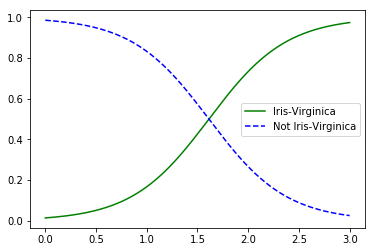

In [144]:
#Lets look at the model's estimated probabilities for flower widths between 0 to 3cm
#X-axis is the width in cm
#Y-axis is the probability prediction of Iris_Virginica vs Not Iris-Virginica
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new) #probability prediction on new X
plt.plot(X_new, y_proba[:, 1], "g-", label = "Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label = "Not Iris-Virginica")
plt.legend()

#As you can see, the classifier is unsure around width 1.6. This will be the decision boundary (which is linear for logistic regression)

### Softmax Regression

Logistic regression can be generalized to support multiple classes directly without having to train and combine binary classifiers (OvO, OvA). This generalization is called Softmax Regression or Multinominal Logistic Regression. The idea is simple:

1. Compute a score sk(x) for each k-class.
2. Estimate the class probability of each class with a softmax function (or normalized exponential). 

The equation to compute the scores is very similar to linear regression. **Note that each class has its own theta parameter**. Then we run these scores into a softmax function. It computes the exponential of every score then normalizes them.

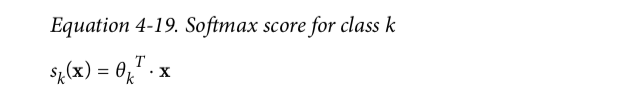

In [145]:
Image(filename = './images/softmax_score.png')

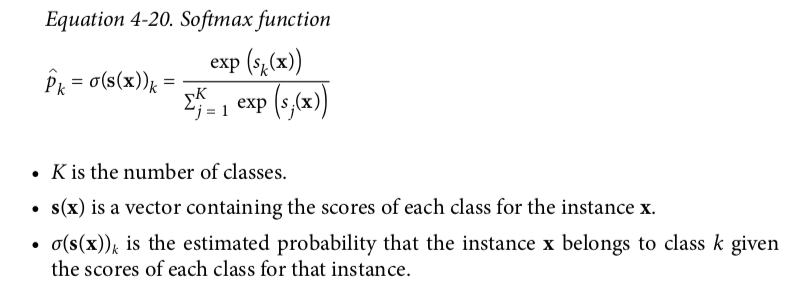

In [146]:
#Exp(Score of class k) / SUM(Exp(Score of any class)) as probability
Image(filename = './images/softmax_function.png')

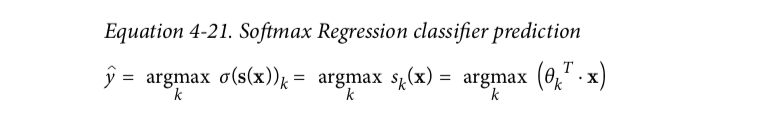

In [147]:
#The prediction is simply choosing class k such that it maximizes the probability prediction
Image(filename = './images/softmax_obj.png')

### Cross-Entropy

To train a model like this, we need to solve a loss function called **cross-entropy**. Cross entropy is frequently used to measure how well a set of estimated class probabilities match the target classes. It is also the general solution to maximum likelihood formulation. 

We should understand cross-entropy from an information theory perspective. Entropy is a measure of **'the lack of order and predictability'** of an event. Imagine crossing the road vs playing russian roulette-- both can lead to death but russian roulette is much more unpredictable, hence higher entropy. Information itself is stored as bits (1/0) in digital form. A byte contains 8 bits, which allows for 2^8 = 256 combinations of 1s and 0s. The idea is that more predictable events require fewer bits to store. Generally, you can use simple (e.g. 1 bit for no meteor crashing down today) to represent highly predictable, and then additional bits to represent less predictable events.

**Cross-entropy measures the average number of bits you actually send per option.** If you assumptions of the prior distribution (e.g. your model believes it'll always be sunny) is correct, then 


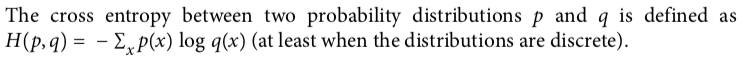

In [148]:
#P(x) is the target distribution and q(x) is the model approximation of the distribution
Image(filename = './images/entropy.png')

In [151]:
X = iris["data"][:, (2, 3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class = "multinomial", solver = 'lbfgs', C = 10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [152]:
softmax_reg.predict([[5, 2]])

array([2])

In [153]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])